In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"
unwanted_cols = ["SHOOTER_ID","ASSISTER_ID","BLOCKER_ID","STEALER_ID","REBOUNDER_ID","TURNOVER_ID"]

# Identify shard files
train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Register Functions for Lambda Layers
##############################################
@tf.keras.utils.register_keras_serializable(package="Custom")
def slice_offense(t):
    return t[:, :5, :]

@tf.keras.utils.register_keras_serializable(package="Custom")
def slice_defense(t):
    return t[:, 5:, :]

@tf.keras.utils.register_keras_serializable(package="Custom")
def mean_axis_1(t):
    return tf.reduce_mean(t, axis=1)

##############################################
# Model Definition Using Embeddings (with updated v)
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

offense_emb = layers.Lambda(slice_offense, name='offense_slice')(player_embedding)
defense_emb = layers.Lambda(slice_defense, name='defense_slice')(player_embedding)

off_mean = layers.Lambda(mean_axis_1, name='off_mean')(offense_emb)
def_mean = layers.Lambda(mean_axis_1, name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

optimizer = SGD(learning_rate=0.01, momentum=0.9)
# or optimizer = Adam(learning_rate=0.0001) if you prefer

model = Model(inputs=input_players, outputs=[main_out, second_chance_out])
model.compile(
    optimizer=optimizer,
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def shard_generator(file_list, main_col, sc_col, mapping):
    """
    Yields individual samples (X, (y_main, y_sc)) from shard files.
    Applies player_to_index mapping to ensure IDs are in [0, v-1].
    """
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)

        # Drop rows with NaNs in player columns
        df = df.dropna(subset=player_columns)

        # Convert players to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Drop unwanted columns
        for c in unwanted_cols:
            if c in df.columns:
                df.drop(columns=c, inplace=True)

        # One-hot the outcome column
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Drop target columns now
        df.drop(columns=[main_col, sc_col], inplace=True)

        # Map player IDs
        for c in player_columns:
            df[c] = df[c].map(mapping)

        X = df[player_columns].values.astype(np.int32)

        # Yield each sample
        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

##############################################
# Create Datasets using mapping
##############################################
train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

##############################################
# Training with tf.data
##############################################
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

##############################################
# Evaluation
##############################################
model.evaluate(test_ds)

##############################################
# Saving the Model
##############################################
model.save('model_one.keras')

# Loading the model later (in a new session), just run:
# loaded_model = tf.keras.models.load_model('model_one.keras')

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 961
Example mapping: [(1713, 0), (2544, 1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 8)     │      7,688 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 8)      │          0 │ player_embedding… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 8)         │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 8)         │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 16)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_out (Dense)    │ (None, 14)        │      1,806 │ hidden[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_chance_out   │ (None, 1)         │        129 │ hidden[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,799 (46.09 KB)

 Trainable params: 11,799 (46.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
Loading shard: split_data_parquet/train_000.parquet
   1751/Unknown 7s 3ms/step - loss: 2.4779 - main_out_accuracy: 0.3581 - main_out_loss: 2.1104 - second_chance_out_accuracy: 0.8896 - second_chance_out_loss: 0.3676Loading shard: split_data_parquet/train_001.parquet
   3666/Unknown 14s 4ms/step - loss: 2.4468 - main_out_accuracy: 0.3596 - main_out_loss: 2.0870 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 0.3598Loading shard: split_data_parquet/train_002.parquet
   5582/Unknown 21s 4ms/step - loss: 2.4339 - main_out_accuracy: 0.3601 - main_out_loss: 2.0768 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3571Loading shard: split_data_parquet/train_003.parquet
   7498/Unknown 27s 4ms/step - loss: 2.4261 - main_out_accuracy: 0.3605 - main_out_loss: 2.0705 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3557Loading shard: split_data_parquet/train_004.parquet
   9419/Unknown 35s 4ms/step - loss: 2.4212 - main_out_accuracy: 0.360

2024-12-09 23:42:28.172984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - loss: 2.4094 - main_out_accuracy: 0.3612 - main_out_loss: 2.0562 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3531 - val_loss: 2.3870 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0345 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3516
Epoch 2/10


2024-12-09 23:42:37.688517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1757/19153 ━━━━━━━━━━━━━━━━━━━━ 1:10 4ms/step - loss: 2.3819 - main_out_accuracy: 0.3602 - main_out_loss: 2.0349 - second_chance_out_accuracy: 0.8896 - second_chance_out_loss: 0.3470Loading shard: split_data_parquet/train_001.parquet
 3665/19153 ━━━━━━━━━━━━━━━━━━━━ 1:02 4ms/step - loss: 2.3843 - main_out_accuracy: 0.3607 - main_out_loss: 2.0359 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 0.3484Loading shard: split_data_parquet/train_002.parquet
 5580/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3851 - main_out_accuracy: 0.3609 - main_out_loss: 2.0362 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3489Loading shard: split_data_parquet/train_003.parquet
 7492/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3851 - main_out_accuracy: 0.3611 - main_out_loss: 2.0360 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3492Loading shard: split_data_parquet/train_004.parquet
 9415/1915

2024-12-09 23:43:55.493020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - loss: 2.3856 - main_out_accuracy: 0.3615 - main_out_loss: 2.0355 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3501 - val_loss: 2.3833 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0306 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3515
Epoch 3/10


2024-12-09 23:44:04.526290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1749/19153 ━━━━━━━━━━━━━━━━━━━━ 1:09 4ms/step - loss: 2.3789 - main_out_accuracy: 0.3588 - main_out_loss: 2.0332 - second_chance_out_accuracy: 0.8900 - second_chance_out_loss: 0.3458Loading shard: split_data_parquet/train_001.parquet
 3669/19153 ━━━━━━━━━━━━━━━━━━━━ 1:02 4ms/step - loss: 2.3807 - main_out_accuracy: 0.3601 - main_out_loss: 2.0332 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 0.3476Loading shard: split_data_parquet/train_002.parquet
 5579/19153 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 2.3814 - main_out_accuracy: 0.3605 - main_out_loss: 2.0331 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3483Loading shard: split_data_parquet/train_003.parquet
 7504/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3814 - main_out_accuracy: 0.3608 - main_out_loss: 2.0328 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3486Loading shard: split_data_parquet/train_004.parquet
 9408/1915

2024-12-09 23:45:22.481289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - loss: 2.3819 - main_out_accuracy: 0.3613 - main_out_loss: 2.0323 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3496 - val_loss: 2.3806 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0283 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3514
Epoch 4/10


2024-12-09 23:45:31.918852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1750/19153 ━━━━━━━━━━━━━━━━━━━━ 1:10 4ms/step - loss: 2.3772 - main_out_accuracy: 0.3606 - main_out_loss: 2.0285 - second_chance_out_accuracy: 0.8883 - second_chance_out_loss: 0.3488Loading shard: split_data_parquet/train_001.parquet
 3668/19153 ━━━━━━━━━━━━━━━━━━━━ 1:03 4ms/step - loss: 2.3785 - main_out_accuracy: 0.3609 - main_out_loss: 2.0297 - second_chance_out_accuracy: 0.8883 - second_chance_out_loss: 0.3488Loading shard: split_data_parquet/train_002.parquet
 5584/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3790 - main_out_accuracy: 0.3610 - main_out_loss: 2.0300 - second_chance_out_accuracy: 0.8882 - second_chance_out_loss: 0.3489Loading shard: split_data_parquet/train_003.parquet
 7500/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3789 - main_out_accuracy: 0.3612 - main_out_loss: 2.0299 - second_chance_out_accuracy: 0.8882 - second_chance_out_loss: 0.3490Loading shard: split_data_parquet/train_004.parquet
 9415/1915

2024-12-09 23:46:50.223509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3793 - main_out_accuracy: 0.3615 - main_out_loss: 2.0298 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3495 - val_loss: 2.3800 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0284 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3511
Epoch 5/10


2024-12-09 23:46:59.739665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1748/19153 ━━━━━━━━━━━━━━━━━━━━ 1:11 4ms/step - loss: 2.3703 - main_out_accuracy: 0.3607 - main_out_loss: 2.0257 - second_chance_out_accuracy: 0.8902 - second_chance_out_loss: 0.3445Loading shard: split_data_parquet/train_001.parquet
 3665/19153 ━━━━━━━━━━━━━━━━━━━━ 1:03 4ms/step - loss: 2.3741 - main_out_accuracy: 0.3609 - main_out_loss: 2.0275 - second_chance_out_accuracy: 0.8892 - second_chance_out_loss: 0.3466Loading shard: split_data_parquet/train_002.parquet
 5583/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3754 - main_out_accuracy: 0.3610 - main_out_loss: 2.0281 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3473Loading shard: split_data_parquet/train_003.parquet
 7493/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3757 - main_out_accuracy: 0.3612 - main_out_loss: 2.0280 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3477Loading shard: split_data_parquet/train_004.parquet
 9416/1915

2024-12-09 23:48:18.434023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3768 - main_out_accuracy: 0.3615 - main_out_loss: 2.0280 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3488 - val_loss: 2.3784 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0267 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3507
Epoch 6/10


2024-12-09 23:48:27.939533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1750/19153 ━━━━━━━━━━━━━━━━━━━━ 1:11 4ms/step - loss: 2.3719 - main_out_accuracy: 0.3600 - main_out_loss: 2.0254 - second_chance_out_accuracy: 0.8892 - second_chance_out_loss: 0.3464Loading shard: split_data_parquet/train_001.parquet
 3664/19153 ━━━━━━━━━━━━━━━━━━━━ 1:02 4ms/step - loss: 2.3741 - main_out_accuracy: 0.3606 - main_out_loss: 2.0267 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3474Loading shard: split_data_parquet/train_002.parquet
 5578/19153 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 2.3749 - main_out_accuracy: 0.3608 - main_out_loss: 2.0271 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3478Loading shard: split_data_parquet/train_003.parquet
 7501/19153 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 2.3750 - main_out_accuracy: 0.3611 - main_out_loss: 2.0270 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3480Loading shard: split_data_parquet/train_004.parquet
 9409/1915

2024-12-09 23:49:45.941768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3757 - main_out_accuracy: 0.3614 - main_out_loss: 2.0269 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3488 - val_loss: 2.3780 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0262 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509
Epoch 7/10


2024-12-09 23:49:55.451905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1747/19153 ━━━━━━━━━━━━━━━━━━━━ 1:10 4ms/step - loss: 2.3672 - main_out_accuracy: 0.3607 - main_out_loss: 2.0225 - second_chance_out_accuracy: 0.8900 - second_chance_out_loss: 0.3447Loading shard: split_data_parquet/train_001.parquet
 3667/19153 ━━━━━━━━━━━━━━━━━━━━ 1:03 4ms/step - loss: 2.3712 - main_out_accuracy: 0.3610 - main_out_loss: 2.0246 - second_chance_out_accuracy: 0.8892 - second_chance_out_loss: 0.3465Loading shard: split_data_parquet/train_002.parquet
 5586/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3726 - main_out_accuracy: 0.3611 - main_out_loss: 2.0253 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 0.3472Loading shard: split_data_parquet/train_003.parquet
 7502/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3730 - main_out_accuracy: 0.3613 - main_out_loss: 2.0254 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3476Loading shard: split_data_parquet/train_004.parquet
 9414/1915

2024-12-09 23:51:13.965813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3744 - main_out_accuracy: 0.3615 - main_out_loss: 2.0257 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3486 - val_loss: 2.3775 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0258 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3508
Epoch 8/10


2024-12-09 23:51:23.228889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1756/19153 ━━━━━━━━━━━━━━━━━━━━ 1:10 4ms/step - loss: 2.3706 - main_out_accuracy: 0.3601 - main_out_loss: 2.0241 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 0.3465Loading shard: split_data_parquet/train_001.parquet
 3671/19153 ━━━━━━━━━━━━━━━━━━━━ 1:03 4ms/step - loss: 2.3727 - main_out_accuracy: 0.3607 - main_out_loss: 2.0252 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3475Loading shard: split_data_parquet/train_002.parquet
 5584/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3732 - main_out_accuracy: 0.3609 - main_out_loss: 2.0254 - second_chance_out_accuracy: 0.8885 - second_chance_out_loss: 0.3478Loading shard: split_data_parquet/train_003.parquet
 7503/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3733 - main_out_accuracy: 0.3611 - main_out_loss: 2.0253 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3480Loading shard: split_data_parquet/train_004.parquet
 9407/1915

2024-12-09 23:52:42.061325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3740 - main_out_accuracy: 0.3615 - main_out_loss: 2.0252 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3488 - val_loss: 2.3772 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0251 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3510
Epoch 9/10


2024-12-09 23:52:51.685074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1746/19153 ━━━━━━━━━━━━━━━━━━━━ 1:12 4ms/step - loss: 2.3706 - main_out_accuracy: 0.3607 - main_out_loss: 2.0226 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3480Loading shard: split_data_parquet/train_001.parquet
 3665/19153 ━━━━━━━━━━━━━━━━━━━━ 1:04 4ms/step - loss: 2.3722 - main_out_accuracy: 0.3610 - main_out_loss: 2.0242 - second_chance_out_accuracy: 0.8884 - second_chance_out_loss: 0.3481Loading shard: split_data_parquet/train_002.parquet
 5580/19153 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 2.3728 - main_out_accuracy: 0.3611 - main_out_loss: 2.0246 - second_chance_out_accuracy: 0.8883 - second_chance_out_loss: 0.3483Loading shard: split_data_parquet/train_003.parquet
 7492/19153 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 2.3729 - main_out_accuracy: 0.3613 - main_out_loss: 2.0246 - second_chance_out_accuracy: 0.8883 - second_chance_out_loss: 0.3483Loading shard: split_data_parquet/train_004.parquet
 9408/1915

2024-12-09 23:54:10.253516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3735 - main_out_accuracy: 0.3615 - main_out_loss: 2.0247 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3488 - val_loss: 2.3768 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0249 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3511
Epoch 10/10


2024-12-09 23:54:19.754214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1757/19153 ━━━━━━━━━━━━━━━━━━━━ 1:11 4ms/step - loss: 2.3683 - main_out_accuracy: 0.3601 - main_out_loss: 2.0231 - second_chance_out_accuracy: 0.8897 - second_chance_out_loss: 0.3452Loading shard: split_data_parquet/train_001.parquet
 3665/19153 ━━━━━━━━━━━━━━━━━━━━ 1:03 4ms/step - loss: 2.3708 - main_out_accuracy: 0.3607 - main_out_loss: 2.0242 - second_chance_out_accuracy: 0.8890 - second_chance_out_loss: 0.3466Loading shard: split_data_parquet/train_002.parquet
 5585/19153 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 2.3717 - main_out_accuracy: 0.3608 - main_out_loss: 2.0245 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 0.3472Loading shard: split_data_parquet/train_003.parquet
 7503/19153 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 2.3719 - main_out_accuracy: 0.3611 - main_out_loss: 2.0244 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 0.3475Loading shard: split_data_parquet/train_004.parquet
 9418/1915

2024-12-09 23:55:38.415156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 2.3728 - main_out_accuracy: 0.3614 - main_out_loss: 2.0243 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3485 - val_loss: 2.3765 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0245 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3509


2024-12-09 23:55:47.866578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/test_000.parquet
   1030/Unknown 5s 4ms/step - loss: 2.3849 - main_out_accuracy: 0.3600 - main_out_loss: 2.0310 - second_chance_out_accuracy: 0.8856 - second_chance_out_loss: 0.3540Loading shard: split_data_parquet/test_001.parquet
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.3811 - main_out_accuracy: 0.3604 - main_out_loss: 2.0299 - second_chance_out_accuracy: 0.8870 - second_chance_out_loss: 0.3512


2024-12-09 23:55:57.332967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
 # code to analyze


# not important

In [8]:
model.save('model_one.keras')

In [9]:
model_load = tf.keras.models.load_model('model_one.keras')

In [11]:
import pandas as pd

# After training the model and having player_to_index, unique_players defined:
embedding_matrix = model.get_layer('player_embedding').get_weights()[0]

# Create a DataFrame for player embeddings
# Columns: ['player_id', 'embed_0', 'embed_1', ..., 'embed_{embedding_dim-1}']
columns = ['player_id'] + [f'embed_{d}' for d in range(embedding_matrix.shape[1])]

data = []
for p, i in player_to_index.items():
    # embedding_matrix[i] is the embedding vector for player p
    row = [p] + embedding_matrix[i].tolist()
    data.append(row)

df = pd.DataFrame(data, columns=columns)

# Save to a CSV file
output_csv = 'player_embeddings_one.csv'
df.to_csv(output_csv, index=False)

print(f"Saved player embeddings to {output_csv}")

Saved player embeddings to player_embeddings_one.csv


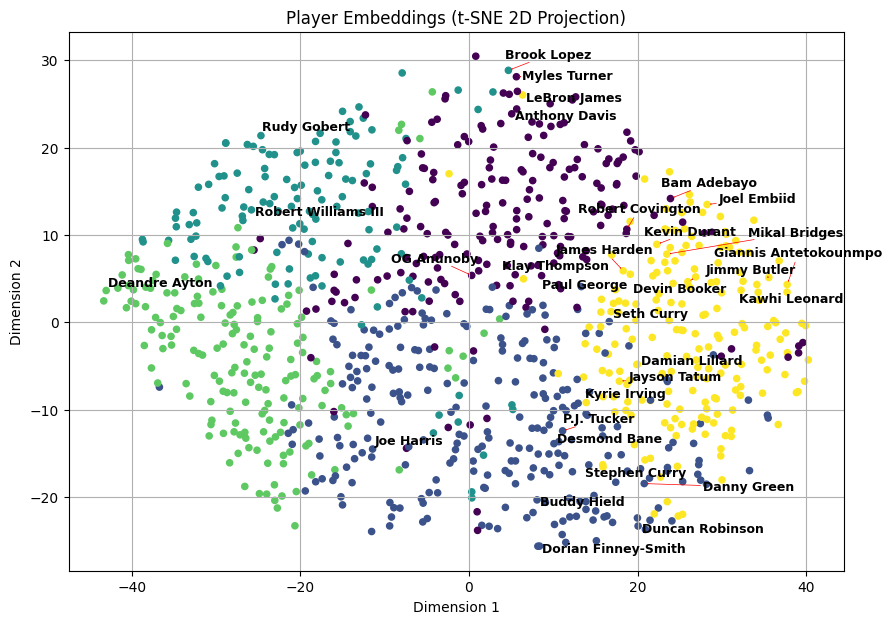

In [26]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from adjustText import adjust_text

# Load the embeddings from the CSV
df = pd.read_csv('player_embeddings_one.csv')  # Ensure the CSV path is correct

player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Run TSNE on vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(vectors)

x_coords = tsne_coords[:, 0]
y_coords = tsne_coords[:, 1]

# Perform K-Means clustering (optional, just to color by cluster)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

# Get NBA players list and create a dict id->full_name
all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

plt.figure(figsize=(10, 7))
plt.scatter(x_coords, y_coords, s=20, c=cluster_labels, cmap='viridis')

texts = []

# Define a set of famous players including more centers, 3&D players, and shooters
famous_players = {
    # Stars from before
    "LeBron James", "Stephen Curry", "Kevin Durant", "Giannis Antetokounmpo", 
    "James Harden", "Kawhi Leonard", "Anthony Davis", "Nikola Jokic", 
    "Joel Embiid", "Luka Doncic", "Damian Lillard", "Jayson Tatum", 
    "Devin Booker", "Jimmy Butler", "Kyrie Irving", "Paul George",
    "Rudy Gobert", "Brook Lopez", "Mikal Bridges", "Klay Thompson",

    # Additional Centers
    "Bam Adebayo", "Myles Turner", "Jonas Valanciunas", "Deandre Ayton", "Robert Williams III",

    # Additional 3&D Players
    "P.J. Tucker", "Robert Covington", "Danny Green", "Dorian Finney-Smith", "OG Anunoby",

    # Additional Shooters
    "Joe Harris", "Buddy Hield", "Duncan Robinson", "Seth Curry", "Desmond Bane"
}

# Label only famous players if they appear
for i, pid in enumerate(player_ids):
    player_name = id_to_name.get(pid, None)
    if player_name in famous_players:
        # Label this famous player
        text_obj = plt.text(x_coords[i], y_coords[i], player_name, fontsize=9, fontweight='bold')
        texts.append(text_obj)

plt.title("Player Embeddings (t-SNE 2D Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)

# Adjust text positions to avoid overlap
if texts:
    labeled_x = [t.get_position()[0] for t in texts]
    labeled_y = [t.get_position()[1] for t in texts]
    adjust_text(texts, x=labeled_x, y=labeled_y, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.show()

In [21]:
from nba_api.stats.static import players

a = players.find_player_by_id("1627209")

In [59]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# LeBron James player_id in nba_api:
lebron_id = 2544
if lebron_id not in id_to_index:
    raise ValueError("LeBron James (player_id=2544) not found in embeddings CSV.")

lebron_idx = id_to_index[lebron_id]
lebron_vec = vectors[lebron_idx].reshape(1, -1)

# Compute cosine similarity between LeBron and all other players
similarities = cosine_similarity(lebron_vec, vectors)[0]  # shape (num_players,)

# Set LeBron's own similarity to -inf
similarities[lebron_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to LeBron James:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to LeBron James:
1. Kristaps Porziņģis (ID: 204001), similarity: 0.9477
2. Chet Holmgren (ID: 1631096), similarity: 0.9294
3. Myles Turner (ID: 1626167), similarity: 0.8483
4. Chris Paul (ID: 101108), similarity: 0.8223
5. Mikal Bridges (ID: 1628969), similarity: 0.8152
6. Cason Wallace (ID: 1641717), similarity: 0.8138
7. Aaron Wiggins (ID: 1630598), similarity: 0.8034
8. Derrick Jones Jr. (ID: 1627884), similarity: 0.8011
9. Anthony Davis (ID: 203076), similarity: 0.8000
10. Kevin Durant (ID: 201142), similarity: 0.7814
11. Derrick White (ID: 1628401), similarity: 0.7668
12. Jaren Jackson Jr. (ID: 1628991), similarity: 0.7645
13. Jalen Johnson (ID: 1630552), similarity: 0.7630
14. Vasilije Micić (ID: 203995), similarity: 0.7483
15. P.J. Washington (ID: 1629023), similarity: 0.7330
16. Herbert Jones (ID: 1630529), similarity: 0.7326
17. Evan Mobley (ID: 1630596), similarity: 0.7313
18. Marco Belinelli (ID: 201158), similarity: 0.7304
19. Braxton Key (ID: 1630296)

In [60]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure correct path
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Stephen Curry player_id in nba_api:
curry_id = 201939
if curry_id not in id_to_index:
    raise ValueError("Stephen Curry (player_id=201939) not found in embeddings CSV.")

curry_idx = id_to_index[curry_id]
curry_vec = vectors[curry_idx].reshape(1, -1)

# Compute cosine similarity between Curry and all other players
similarities = cosine_similarity(curry_vec, vectors)[0]  # shape (num_players,)

# Set Curry's own similarity to -inf so he doesn't appear as his own closest match
similarities[curry_idx] = -np.inf

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]  # descending order
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Stephen Curry:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Stephen Curry:
1. James Harden (ID: 201935), similarity: 0.8491
2. Isaiah Roby (ID: 1629676), similarity: 0.7995
3. Lonzo Ball (ID: 1628366), similarity: 0.7480
4. Buddy Hield (ID: 1627741), similarity: 0.7215
5. Sam Hauser (ID: 1630573), similarity: 0.7188
6. Marvin Williams (ID: 101107), similarity: 0.6842
7. 1629777 (ID: 1629777), similarity: 0.6750
8. Andre Iguodala (ID: 2738), similarity: 0.6729
9. Tyrese Haliburton (ID: 1630169), similarity: 0.6720
10. Devin Vassell (ID: 1630170), similarity: 0.6658
11. Shabazz Napier (ID: 203894), similarity: 0.6612
12. Nicolas Batum (ID: 201587), similarity: 0.6571
13. Mason Jones (ID: 1630222), similarity: 0.6528
14. D'Angelo Russell (ID: 1626156), similarity: 0.6509
15. Derrick White (ID: 1628401), similarity: 0.6495
16. Mamadi Diakite (ID: 1629603), similarity: 0.6420
17. Keyonte George (ID: 1641718), similarity: 0.6417
18. Theo Pinson (ID: 1629033), similarity: 0.6369
19. DJ Steward (ID: 1630569), similarity: 0.6309

In [61]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jayson Tatum's player_id in nba_api:
tatum_id = 1628369
if tatum_id not in id_to_index:
    raise ValueError("Jayson Tatum (player_id=1628369) not found in embeddings CSV.")

tatum_idx = id_to_index[tatum_id]
tatum_vec = vectors[tatum_idx].reshape(1, -1)

# Compute cosine similarity between Tatum and all other players
similarities = cosine_similarity(tatum_vec, vectors)[0]  # shape (num_players,)

# Set Tatum's own similarity to -inf so he doesn't appear as his own closest match
similarities[tatum_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jayson Tatum:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jayson Tatum:
1. Spencer Dinwiddie (ID: 203915), similarity: 0.8769
2. Desmond Bane (ID: 1630217), similarity: 0.8428
3. Bogdan Bogdanović (ID: 203992), similarity: 0.8284
4. Jrue Holiday (ID: 201950), similarity: 0.8276
5. Immanuel Quickley (ID: 1630193), similarity: 0.8272
6. Damian Lillard (ID: 203081), similarity: 0.8231
7. Andrew Wiggins (ID: 203952), similarity: 0.8153
8. Cole Anthony (ID: 1630175), similarity: 0.8145
9. Dean Wade (ID: 1629731), similarity: 0.7983
10. Luka Dončić (ID: 1629029), similarity: 0.7841
11. Luguentz Dort (ID: 1629652), similarity: 0.7797
12. Haywood Highsmith (ID: 1629312), similarity: 0.7509
13. Lamar Stevens (ID: 1630205), similarity: 0.7481
14. Royce O'Neale (ID: 1626220), similarity: 0.7409
15. Reggie Jackson (ID: 202704), similarity: 0.7388
16. Jevon Carter (ID: 1628975), similarity: 0.7383
17. Kyrie Irving (ID: 202681), similarity: 0.7302
18. Pat Connaughton (ID: 1626192), similarity: 0.7160
19. Austin Reaves (ID: 1630559)

In [62]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Jaylen Brown's player_id in nba_api:
brown_id = 1627759
if brown_id not in id_to_index:
    raise ValueError("Jaylen Brown (player_id=1627759) not found in embeddings CSV.")

brown_idx = id_to_index[brown_id]
brown_vec = vectors[brown_idx].reshape(1, -1)

# Compute cosine similarity between Brown and all other players
similarities = cosine_similarity(brown_vec, vectors)[0]  # shape (num_players,)

# Set Brown's own similarity to -inf so he doesn't appear as his own closest match
similarities[brown_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Jaylen Brown:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Jaylen Brown:
1. Derrick Jones Jr. (ID: 1627884), similarity: 0.8981
2. Austin Reaves (ID: 1630559), similarity: 0.8568
3. Tyrone Wallace (ID: 1627820), similarity: 0.8391
4. Kyle Kuzma (ID: 1628398), similarity: 0.8370
5. Bryce McGowens (ID: 1631121), similarity: 0.8358
6. Lou Williams (ID: 101150), similarity: 0.8335
7. Lamar Stevens (ID: 1630205), similarity: 0.8318
8. Ochai Agbaji (ID: 1630534), similarity: 0.8291
9. Montrezl Harrell (ID: 1626149), similarity: 0.8103
10. Jonathan Kuminga (ID: 1630228), similarity: 0.8059
11. Trae Young (ID: 1629027), similarity: 0.7953
12. Devin Booker (ID: 1626164), similarity: 0.7914
13. Kevin Durant (ID: 201142), similarity: 0.7836
14. Kai Jones (ID: 1630539), similarity: 0.7698
15. Saben Lee (ID: 1630240), similarity: 0.7654
16. Ja Morant (ID: 1629630), similarity: 0.7626
17. Christian Wood (ID: 1626174), similarity: 0.7560
18. Russell Westbrook (ID: 201566), similarity: 0.7445
19. Dereon Seabron (ID: 1631220), similari

In [63]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings from CSV
df = pd.read_csv('player_embeddings.csv')  # Ensure the path is correct
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values  # shape (num_players, embedding_dim)

# Mapping from player_id to row index
id_to_index = {pid: idx for idx, pid in enumerate(player_ids)}

# Rudy Gobert's player_id in nba_api:
gobert_id = 203497
if gobert_id not in id_to_index:
    raise ValueError("Rudy Gobert (player_id=203497) not found in embeddings CSV.")

gobert_idx = id_to_index[gobert_id]
gobert_vec = vectors[gobert_idx].reshape(1, -1)

# Compute cosine similarity between Gobert and all other players
similarities = cosine_similarity(gobert_vec, vectors)[0]  # shape (num_players,)

# Set Gobert's own similarity to -inf so he doesn't appear as his own closest match
similarities[gobert_idx] = -np.inf

# Sort by similarity descending
sorted_indices = np.argsort(similarities)[::-1]
top_5_indices = sorted_indices[:20]

all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

print("Top 5 players closest to Rudy Gobert:")
for rank, idx_ in enumerate(top_5_indices, start=1):
    pid = player_ids[idx_]
    pname = id_to_name.get(pid, str(pid))
    sim = similarities[idx_]
    print(f"{rank}. {pname} (ID: {pid}), similarity: {sim:.4f}")

Top 5 players closest to Rudy Gobert:
1. DeAndre Jordan (ID: 201599), similarity: 0.8467
2. GG Jackson (ID: 1641713), similarity: 0.7997
3. 1630289 (ID: 1630289), similarity: 0.7726
4. Luka Samanic (ID: 1629677), similarity: 0.7481
5. Drew Eubanks (ID: 1629234), similarity: 0.7094
6. Montrezl Harrell (ID: 1626149), similarity: 0.6903
7. Joel Embiid (ID: 203954), similarity: 0.6886
8. Kenneth Faried (ID: 202702), similarity: 0.6879
9. Dwight Powell (ID: 203939), similarity: 0.6853
10. Christian Wood (ID: 1626174), similarity: 0.6808
11. Jalen Duren (ID: 1631105), similarity: 0.6790
12. Jarrett Allen (ID: 1628386), similarity: 0.6770
13. 1629081 (ID: 1629081), similarity: 0.6689
14. Keyonte George (ID: 1641718), similarity: 0.6612
15. Isaiah Stewart (ID: 1630191), similarity: 0.6435
16. Serge Ibaka (ID: 201586), similarity: 0.6411
17. Rui Hachimura (ID: 1629060), similarity: 0.6239
18. Noah Clowney (ID: 1641730), similarity: 0.6214
19. Nathan Knight (ID: 1630233), similarity: 0.6198
20. 

In [27]:
import numpy as np

def predict_lineup_points(model, player_ids, player_to_index, num_simulations=100):
    # Convert player_ids to embedding indices
    # player_ids is a list or array of length 10
    lineup_indices = [player_to_index[pid] for pid in player_ids]
    lineup_array = np.array([lineup_indices])  # shape (1,10)
    
    # Get predictions from the model
    # The model outputs: main_out (14 classes), second_chance_out (1 class), and role heads
    # We only need main_out and second_chance_out for scoring.
    predictions = model.predict(lineup_array)  # returns a list of outputs
    # According to code above, outputs are:
    # [main_out, second_chance_out, shooter_out, assister_out, blocker_out, stealer_out, rebounder_out, turnover_out]
    main_out_prob = predictions[0][0]  # shape (14,)
    second_chance_prob = predictions[1][0]  # shape (1,)
    second_chance_p = second_chance_prob[0]

    # Define the point mapping logic as a function
    def get_points_and_extras(outcome):
        # Returns (points, extra_possessions_from_outcome)
        if outcome in [0,1]:
            return 2, 0
        elif outcome in [2,3]:
            return 3, 0
        elif 4 <= outcome <= 8:
            return 0, 0
        elif outcome == 9:
            return 1, 0
        elif outcome == 10:
            return 2, 0
        elif outcome == 11:
            return 3, 0
        elif outcome == 12:
            # Add 1 possession and +1 point
            return 1, 1
        elif outcome == 13:
            # Add 1 possession, +0 points
            return 0, 1
        else:
            # Should not happen, as we have only 0-13 outcomes
            return 0, 0

    total_points = 0
    # Run multiple simulations
    for _ in range(num_simulations):
        points = 0
        base_possessions = 0  # count how many of the "base" 100 possessions we have done
        # We will run until base_possessions >= 100
        # Extra possessions just happen on top of these 100

        while base_possessions < 100:
            # Sample outcome from main_out distribution
            outcome = np.random.choice(np.arange(14), p=main_out_prob)
            # Sample second chance
            second_chance = np.random.rand() < second_chance_p

            # Get points and extra from outcome
            pts, extra_pos = get_points_and_extras(outcome)
            points += pts

            # increment base_possessions by 1 (for the current possession)
            base_possessions += 1

            # Add extra possessions from outcome
            # Each extra possession means we increment base_possessions again
            for _ in range(extra_pos):
                base_possessions += 1
                # On these extra possessions from outcome 12/13 we do not re-sample outcome/second_chance
                # The instruction suggests just add them as a cost of that outcome.
                # If we needed to re-sample for those possessions we would complicate further,
                # but instructions say "Also add one more possession if second chance is set" and "when encounter outcome 12,13 add one more possession"
                # It's ambiguous if we should re-sample a new outcome for extra possessions.
                # The instructions: "Also add one more possession if second chance is set" could imply we do re-run?
                # The instructions are not crystal clear. If we must re-sample for extra possessions, we must do a loop:
                # But let's assume we do not re-sample for these extra possessions; they are just a penalty.
            
            # If second chance is True, add one more possession
            if second_chance:
                base_possessions += 1
                # Similarly, no re-sample. Just consider it a cost.

        total_points += points

    # Average points per simulation
    average_points = total_points / num_simulations
    return average_points

In [32]:
lineup_nuggets_pacers = [
    203999,    # Nikola Jokic
    1627750,   # Jamal Murray
    1629008,   # Michael Porter Jr.
    203932,    # Aaron Gordon
    203484,    # Kentavious Caldwell-Pope
    1629607,   # Tyrese Haliburton
    1627747,   # Buddy Hield
    1626167,   # Myles Turner
    1631096,   # Bennedict Mathurin
    1630174    # Aaron Neysmith
]

average_points = predict_lineup_points(model, lineup_nuggets_pacers, player_to_index, num_simulations=100)
print(f"Expected points in 100 possessions for the 24 Nuggets vs 24 Pacers lineup: {average_points:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Expected points in 100 possessions for the 24 Nuggets vs 24 Pacers lineup: 85.17


In [30]:
lineup_23_nuggets_24_celtics = [
    203999,   # Nikola Jokic
    1627750,  # Jamal Murray
    1629008,  # Michael Porter Jr.
    203932,   # Aaron Gordon
    203484,   # Kentavious Caldwell-Pope
    1628464,  # Jayson Tatum
    1627759,  # Jaylen Brown
    201950,   # Jrue Holiday
    203082,   # Kristaps Porzingis
    1628401   # Derrick White
]

average_points = predict_lineup_points(model, lineup_23_nuggets_24_celtics, player_to_index, num_simulations=100)
print(f"Expected points in 100 possessions for the 23 Nuggets vs 24 Celtics lineup: {average_points:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Expected points in 100 possessions for the 23 Nuggets vs 24 Celtics lineup: 87.20


In [29]:
example_lineup = [2544, 201939, 201142, 203507, 203954, 203999, 202695, 201935, 1629029, 1628464]

average_points = predict_lineup_points(model, example_lineup, player_to_index, num_simulations=100)
print(f"Expected points in 100 possessions for the all-star lineup: {average_points:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Expected points in 100 possessions for the all-star lineup: 93.01
